In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import matplotlib.pyplot as plt
#import torch
from modelling_fctns import double_logistic, normalized_difference
import data_cleaning
import LSP

import libtlda.tca

#import adapt.feature_based

import cv2
from PIL import Image

import scipy.signal
from scipy.interpolate import make_smoothing_spline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#

In [ ]:
lat_station = ds_station['lat'].iloc[0]
lon_station = ds_station['lon'].iloc[0]
if data_type != 'dwd':
    if data_type == 'CIMMYT':
        phen_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')
    elif data_type == 'TAMASA_TZ':
        phen_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_TZ.csv')
    elif data_type == 'TAMASA_ET':
        phen_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_ET.csv')
    SOS = WC_SOS_CIMMYT(lat_station, lon_station, phen_data_CIMMYT = phen_data)
    EOS = WC_EOS_CIMMYT(lat_station, lon_station, phen_data_CIMMYT = phen_data)
else:
    SOS = 

In [54]:
def cross_percentile_date(smoothed_series, percentile):
    # Calculate the 90th percentile
    percentile_value = np.percentile(smoothed_series, percentile)
    # Identify when the time series crosses the 90th percentile
    crosses_percentile_up = (smoothed_series > percentile_value).astype(int).diff().fillna(0) == 1#.astype(bool)
    crosses_percentile_down = (smoothed_series > percentile_value).astype(int).diff().fillna(0) == -1
    # Extract the dates when the crossing occurs
    crossing_dates_up = smoothed_series.index[crosses_percentile_up]
    crossing_dates_down = smoothed_series.index[crosses_percentile_down]
    return *crossing_dates_up, *crossing_dates_down

def double_logistic_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    params, _ = scipy.optimize.curve_fit(modelling_fctns.double_logistic, Times/365, values, maxfev = 10000)
    smoothed_series = pd.Series(modelling_fctns.double_logistic(Tighter_times/365, *params), index=Tighter_times/365)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def spline_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    spl = make_smoothing_spline(Times/365, values, lam = 0.00001)
    smoothed_series = pd.Series(spl(Tighter_times/365), index=Tighter_times/365)
    #print(Tighter_times/365, smoothed_series.idxmax(), smoothed_series)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    print(spl(Tighter_times[np.int64(smoothed_series.idxmax()*365)]/365), max_green, spl(Tighter_times/365).max())
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def savgol_LSP(values, Times, first_date, window_length=50, polyorder=2):
    print(len(values))
    smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0), index=Times)[1:-1]
    smoothed_derivs = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder,  deriv=1), index=Times)[1:-1]
    mingrad = first_date + pd.Timedelta(smoothed_derivs.idxmin(), 'D')
    maxgrad = first_date + pd.Timedelta(smoothed_derivs.idxmax(), 'D')
    minday = first_date + pd.Timedelta(smoothed_series.idxmin(), 'D')
    maxday = first_date + pd.Timedelta(smoothed_series.idxmax(), 'D')
    #percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0], 'D')
    #percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0], 'D')
    if len(cross_percentile_date(smoothed_series, 50)) < 2:
        percentile_50a = first_date - pd.Timedelta(9999, 'D')
        percentile_50b = first_date - pd.Timedelta(9999, 'D')
    else:
        percentile_50a = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0], 'D')
        percentile_50b = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[-1], 'D')
    if len(cross_percentile_date(smoothed_series, 90)) < 2:
        percentile_90a = first_date - pd.Timedelta(9999, 'D')
        percentile_90b = first_date - pd.Timedelta(9999, 'D')
    else:
        percentile_90a = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0], 'D')
        percentile_90b = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[-1], 'D')
    return mingrad, maxgrad, minday, maxday, percentile_50a, percentile_50b, percentile_90a, percentile_90b

def variable_percentiles(values, Times, first_date, window_length=50, polyorder=2):
    smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0), index=Times)[1:-1]
    last_hits = []
    sl_hits = []
    for percentile in range(100):
        percentile_dates = cross_percentile_date(smoothed_series, percentile)
        if percentile_dates[-1] < percentile_dates[0]:
            print(percentile, percentile_dates)
        if len(percentile_dates) < 2:
            last_hits.append(first_date - pd.Timedelta(9999, 'D'))
            sl_hits.append(first_date - pd.Timedelta(9999, 'D'))
        elif len(percentile_dates) < 4:
            sl_hits.append(first_date + pd.Timedelta(percentile_dates[0], 'D'))#-2
            last_hits.append(first_date + pd.Timedelta(percentile_dates[-1], 'D'))#-1
        else:
            sl_hits.append(first_date + pd.Timedelta(percentile_dates[0], 'D'))#-2
            last_hits.append(first_date + pd.Timedelta(percentile_dates[-1], 'D'))#-1
    return *sl_hits, *last_hits
    

def variable_thresholds(values, Times, first_date, threshold_percentages = np.arange(0, 1, 0.05), smooth = True, window_length=4, polyorder=2):
    LSP_SOS_index = scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0)[:(len(values)//4)].argmin()
    restricted_values = scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0)#values[LSP_SOS_index:]
    restricted_Times = Times#[LSP_SOS_index:]
    minvalue = restricted_values.min()
    maxvalue = restricted_values.max()
    thresholds = minvalue + (maxvalue - minvalue)*threshold_percentages
    cummax = np.maximum.accumulate(restricted_values)
    cummax_reversed = np.maximum.accumulate(np.flip(restricted_values))
    first_cross_dates = first_date + pd.to_timedelta(restricted_Times[np.digitize(thresholds, cummax)], 'D')
    last_cross_dates = first_date + pd.to_timedelta(np.flip(restricted_Times)[np.digitize(thresholds, cummax_reversed)], 'D')
    print(*first_cross_dates, *last_cross_dates)
    return *first_cross_dates, *last_cross_dates

def savgol_raw(values, Times, first_date, window_length=50, polyorder=2):
    smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0), index=Times)
    return smoothed_series

def initialize_LSP_frame(LSP_method, MVI_window = 8, threshold_percentages = np.arange(0, 1, 0.05)):
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'percentile_10', 'percentile_50', 'percentile_90', 'percentile_10_2nd', 'max_green'])
    elif LSP_method == 'savgol':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'])
    elif LSP_method == 'savgol_raw' or LSP_method == 'MVI_raw': # MVI_window*stepnum
        numsteps = int((200 - (MVI_window - (90 % MVI_window)))//MVI_window) + 1
        first_day = np.datetime64(f'2021-01-01') + np.timedelta64(89 + (MVI_window - (89 % MVI_window)), 'D')#np.datetime64('2021-04-07') 
        results = pd.DataFrame(columns = ['year', 'Stations_Id'] + ['NDVI interpolated at day ' + str((first_day+ np.timedelta64(MVI_window*stepnum, 'D')).item().strftime('%m.%d')) for stepnum in range(numsteps)])
    elif LSP_method == 'variable_thresholds':
        results = pd.DataFrame(columns = ['year', 'Stations_Id'] + [f'first time crossing threshold {int(np.round(threshold*100))}%' for threshold in threshold_percentages] + [f'last time crossing threshold {int(np.round(threshold*100))}%' for threshold in threshold_percentages])
    elif LSP_method == 'variable_percentiles':
        results = pd.DataFrame(columns = ['year', 'Stations_Id'] + [f'first time crossing percentile {int(np.round(threshold*100))}%' for threshold in threshold_percentages] + [f'last time crossing percentile {int(np.round(threshold*100))}%' for threshold in threshold_percentages])
    elif LSP_method == 'linterp_raw':
        results = pd.DataFrame(columns = ['year', 'Stations_Id'] + [f'linterp day {day}' for day in range(200)])
    return results

def append_LSP_frame(results, LSPs):
    results.loc[-1] = LSPs
    results.index = results.index + 1
    results = results.sort_index()
    return results

def calculate_append_LSP_frame(results, values, Times, first_date, LSP_method, year, station, threshold_percentages = np.arange(0, 1, 0.05)):
    #print(len(results.columns), len(values))# 
    #print(results.columns)
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        if LSP_method == 'double_logistic':
            LSPs = double_logistic_LSP(values, Times, first_date)
        else:
            LSPs = spline_LSP(values, Times, first_date)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'savgol':
        LSPs = savgol_LSP(values, Times, first_date, window_length=8, polyorder=2)#14
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'savgol_raw':
        LSPs = savgol_raw(values, Times, first_date, window_length=12, polyorder=2)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'variable_thresholds':
        LSPs = variable_thresholds(values, Times,first_date, threshold_percentages = threshold_percentages)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'variable_percentiles':
        LSPs = variable_percentiles(values, Times,first_date, window_length=14, polyorder=2)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'linterp_raw' or LSP_method == 'MVI_raw':
        #print(results, values)
        #print(len(results), len(values))
        results = append_LSP_frame(results, [year, station, *values])
    return results

def LSP_at_stations(ds, start_year, end_year, 
                    LSP_method = 'double_logistic', interp_method = 'linear', 
                    MVI_window = 8, threshold_percentages = np.arange(0, 1, 0.05), 
                    buffer = 20, data_type = 'dwd', phen_data = None):
    results = initialize_LSP_frame(LSP_method, MVI_window = MVI_window, threshold_percentages = threshold_percentages)
    for year in range(start_year, end_year + 1):
        print(f'Year: {year}')
        for station in ds['Stations_Id'].unique():
            ds_station = ds.loc[ds['Stations_Id'] == station]
            if data_type == 'dwd':
                ds_station_year = data_cleaning.restrict_to_growing_season(ds_station, year, ds_station['SOS'].iloc[0], ds_station['EOS'].iloc[0], buffer = buffer)
            else:
                ds_station['date'] = pd.to_datetime(ds_station['date'])#, format='%Y-%m-%d-%H-%M-%S')
                try:
                    SOS_date = phen_data.loc[(phen_data['Stations_id'] == station) & (phen_data['Referenzjahr'] == year)]['WC SOS date'].values[0]
                except:
                    print('WC SOS not available')
                    continue
                ds_station_year = ds_station.loc[(ds_station['date'] >= SOS_date) & (ds_station['date'] < SOS_date + np.timedelta64(220, 'D'))]
            #print(ds_station_year['date'].min(), ds_station_year['date'].max())
            #if len(ds_station_year) > 7:
            #    print(f'Station {station} in {year} has {len(ds_station_year)} observations')
            if len(ds_station_year) <= 30:
                print(f'Station {station} in {year} has {len(ds_station_year)} observations so ignored')
                continue
            #try:
            if interp_method == 'linear':
                if LSP_method == 'linterp_raw':
                    jan1_rows = ds_station_year.iloc[[0, 1]].copy()
                    jan1_rows.loc[:, 'date'] = np.array([np.datetime64(f'{year}-01-01'), np.datetime64(f'{year}-12-31')])
                    jan1_rows.loc[:, 'NDVI'] = 0.1
                    jan1_rows.loc[:, 'sur_refl_b01'] = 0
                    jan1_rows.loc[:, 'sur_refl_b02'] = 0
                    jan1_rows = jan1_rows.rename(index={jan1_rows.index[0]: 0, jan1_rows.index[1]: 1})
                    ds_station_year = pd.concat([ds_station_year, jan1_rows.rename(index={jan1_rows.index[0]: 0, jan1_rows.index[1]: 1})],ignore_index=True, axis = 0).sort_values('date')
                    #print(ds_station_year)
                ds_interpolated = data_cleaning.resample_linear(ds_station_year)
                days = pd.to_datetime(ds_interpolated['time']).dt.dayofyear
                #print(days)
                ds_interpolated = ds_interpolated.where((days > 90)*(days <=290)).dropna(how='all')
            elif interp_method == 'MVI':
                if LSP_method == 'savgol_raw' or LSP_method == 'MVI_raw':
                    jan1_row = ds_station_year.iloc[0].copy()
                    jan1_row.loc['date'] = np.datetime64(f'{year}-01-01')
                    jan1_row.loc['NDVI'] = 0
                    jan1_row.loc['sur_refl_b01'] = 0
                    jan1_row.loc['sur_refl_b02'] = 0
                    ds_station_year = pd.concat([ds_station_year, jan1_row.rename(index=0).to_frame().T],ignore_index=True, axis = 0).sort_values('date')
                    #print(ds_station_year['date'])
                    ds_interpolated = data_cleaning.map_max_value_int(ds_station_year, window_size=MVI_window) #data_cleaning.
                    ds_interpolated = ds_interpolated.set_index(['time']).resample(f'{MVI_window}D').interpolate().reset_index()
                    days = pd.to_datetime(ds_interpolated['time']).dt.dayofyear 
                    ds_interpolated = ds_interpolated.where((days > 90)*(days <290)).dropna(how='all')
                    #ds_interpolated = ds_interpolated.resample(f'{MVI_window}D').interpolate()
                    #print(ds_interpolated['time'])
                else:
                    ds_interpolated = data_cleaning.map_max_value_int(ds_station_year, window_size=8)
            #except:
            #    print(f'Couldn\'t interpolate station {station} in year {year}')
            #    continue
            ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
            #print(ds_interpolated)
            Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
            NDVIs = ds_interpolated['NDVI'].values
            first_date = ds_interpolated['time'].min()
            if LSP_method == 'savgol_raw' or LSP_method == 'MVI_raw':
                if len(NDVIs) != results.shape[1] - 2:
                    print(len(NDVIs), results.shape[1])
                    continue
            #try:
            results = calculate_append_LSP_frame(results, NDVIs, Times, first_date, LSP_method, year, station, threshold_percentages=threshold_percentages)
            #except:
                #print(f'Couldn\'t compute LSP for station {station} in year {year}')
                #continue
    return results, ds_interpolated

def prepare_obs_for_LSP(ds, instrument='MODIS'):
    if instrument == 'MODIS':
        ds = ds.where(ds['sur_refl_b01'] != -9999).dropna()
        ds = ds.where(ds['reducer'] == 'mean').dropna()
        #ds['NDVI'] = ( ds['sur_refl_b02'] - ds['sur_refl_b01'] ) / ( ds['sur_refl_b02'] + ds['sur_refl_b01'] )
        ds['date'] = pd.to_datetime(ds['date'])
        ds['year'] = ds['date'].dt.year
        ds = data_cleaning.add_EOS_to_df(ds)
        ds = data_cleaning.add_SOS_to_df(ds)
    return ds

def get_LSPs(start_year, end_year, LSP_method = 'double_logistic', 
                interp_method = 'linear', instrument='MODIS', 
                last_index = 1200, step = 40, file_path = 'MODIS\\Germany\\satdata', 
                MVI_window = 8, threshold_percentages = np.arange(0, 1, 0.05),
                buffer = 20, separate_year_files = True, data_type = 'dwd', phen_data = None):
    for first_in_file in np.arange(0, last_index, step):
        if separate_year_files:
            ds_list = []
            print(f'Station {first_in_file}')
            for year in range(start_year, end_year + 1):
                ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}{first_in_file}_{year}.csv')) #Sentinel
            ds = pd.concat(ds_list, axis = 0)
        else:
            ds = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}{first_in_file}.csv')
        #try:
        #    ds = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}\\satdata{first_in_file}_{year}.csv')
        #except:
        #    print(f'File {first_in_file} year {year} failed to load')
        #    continue
        ds = prepare_obs_for_LSP(ds, instrument)
        if first_in_file == 0:
            LSP_times, ds_interpolated = LSP_at_stations(ds, start_year, end_year, LSP_method, interp_method, MVI_window=MVI_window, threshold_percentages = threshold_percentages, buffer = buffer, data_type = data_type)
        else:
            LSP_times = pd.concat([LSP_times, LSP_at_stations(ds, start_year, end_year,
                                                                LSP_method, interp_method, 
                                                                MVI_window=MVI_window, 
                                                                threshold_percentages = threshold_percentages, 
                                                                buffer = buffer, data_type = data_type, 
                                                                phen_data = phen_data)[0]], axis=0)
    return LSP_times

def WC_SOS_CIMMYT(lat, lon, phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')):
    EOS_SOS = phen_data_CIMMYT.loc[(phen_data_CIMMYT['lat'] == lat) & (phen_data_CIMMYT['lon'] == lon)][['SOS', 'EOS']].values[0]
    return EOS_SOS[0]

In [55]:
def add_SOS_EOS_to_df_CIMMYT(df, phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')):
    df['SOS'] = -999
    df['EOS'] = -999
    lat_prev = 1000
    lon_prev = 1000
    for index in df.index:
        lat = df.loc[index]['lat']
        lon = df.loc[index]['lon']
        if lat_prev != lat or lon_prev != lon:
            SOS = WC_SOS_CIMMYT(lat, lon, phen_data_CIMMYT)
            EOS = WC_EOS_CIMMYT(lat, lon, phen_data_CIMMYT)
            lat_prev = lat
            lon_prev = lon
            print(lat, lon)
        #print(phen_data_CIMMYT.loc[index]['lat'])
        df.loc[index, 'SOS'] = SOS
        df.loc[index, 'EOS'] = EOS
    return df

def add_EOS_to_df(df):
    df['EOS'] = WC_EOS(df['lon'], df['lat'])
    return df

def WC_date_from_columns(ds, phase):
    #### yrcode must be the year of the observation ####
    ds.loc[:, 'WC SOS date'] = pd.to_datetime(ds.loc[:, 'yrcode'], format = '%Y') + pd.to_timedelta(ds['SOS'], 'D')
    wrong_year = ((ds[f'observed time to {phase}'] - ds['WC SOS date']).dt.days < 0)
    ds.loc[wrong_year, 'WC SOS date'] = ds.loc[wrong_year, 'WC SOS date'] - np.timedelta64(365, 'D')
    out_of_season = ((ds[f'observed time to {phase}'] - ds['WC SOS date']).dt.days > 170) & (ds['SOS2'] > 0)
    ds.loc[out_of_season, 'WC SOS date'] = pd.to_datetime(ds.loc[:, 'yrcode'], format = '%Y') + pd.to_timedelta(ds['SOS2'], 'D')
    wrong_year = ((ds[f'observed time to {phase}'] - ds['WC SOS date']).dt.days < 0)
    ds.loc[out_of_season & wrong_year, 'WC SOS date'] = ds.loc[out_of_season & wrong_year, 'WC SOS date'] - np.timedelta64(365, 'D')
    ds = ds.rename(columns={'yrcode': 'Referenzjahr'})
    return ds

In [56]:
def columns_to_datetime(ds, columns):
    for colname in columns:
        ds[colname] = pd.to_datetime(ds[colname], format='mixed')
    return ds

In [68]:
phen_data_TZ = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_TZ.csv')
phen_data_TZ = columns_to_datetime(phen_data_TZ, ['flowering date', 'emergence date', 'maturity date'])
phen_data_TZ = phen_data_TZ.rename(columns={'station': 'Stations_id', 'flowering date': 'observed time to beginning of flowering'})
phen_data_TZ['yrcode'] = phen_data_TZ['observed time to beginning of flowering'].dt.year
phen_data_TZ = phen_data_TZ[['lat', 'lon', 'Stations_id', 'observed time to beginning of flowering', 'yrcode', 'SOS', 'EOS', 'SOS2', 'EOS2']].groupby(['Stations_id', 'yrcode', 'lat', 'lon']).mean().reset_index()
phen_data_TZ = WC_date_from_columns(phen_data_TZ, 'beginning of flowering')
phen_data_ET = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_ET.csv')
phen_data_ET = columns_to_datetime(phen_data_ET, ['flowering date', 'emergence date', 'maturity date'])
phen_data_ET = phen_data_ET.rename(columns={'Site no. = EXPsit': 'Stations_id', 'flowering date': 'observed time to beginning of flowering'})
phen_data_ET['yrcode'] = phen_data_ET['observed time to beginning of flowering'].dt.year
phen_data_ET = phen_data_ET[['lat', 'lon', 'Stations_id', 'observed time to beginning of flowering', 'yrcode', 'SOS', 'EOS', 'SOS2', 'EOS2']].groupby(['Stations_id', 'yrcode', 'lat', 'lon']).mean().reset_index()
phen_data_ET = WC_date_from_columns(phen_data_ET, 'beginning of flowering')
phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')
phen_data_CIMMYT = columns_to_datetime(phen_data_CIMMYT, ['PlantingDate', 'AnthesisDate', 'DaysToSilk'])
phen_data_CIMMYT['observed time to beginning of flowering'] = phen_data_CIMMYT['AnthesisDate']
phen_data_CIMMYT['yrcode'] = phen_data_CIMMYT['observed time to beginning of flowering'].dt.year
phen_data_CIMMYT = phen_data_CIMMYT[['lat', 'lon', 'sitecode', 'observed time to beginning of flowering', 'PlantingDate', 'yrcode', 'SOS', 'EOS', 'SOS2', 'EOS2']].groupby(['sitecode', 'yrcode', 'lat', 'lon']).mean().reset_index()
phen_data_CIMMYT = WC_date_from_columns(phen_data_CIMMYT, 'beginning of flowering')
phen_data_CIMMYT = phen_data_CIMMYT.rename(columns={'sitecode': 'Stations_id',})
phen_data_CIMMYT = phen_data_CIMMYT.where((phen_data_CIMMYT['observed time to beginning of flowering'] - phen_data_CIMMYT['WC SOS date']).dt.days < 240)

In [69]:
obs_data

,sitecode,year,lat,lon,observed time to beginning of flowering,PlantingDate,SOS,EOS,SOS2,EOS2,WC SOS date
0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT
1,6.0,2004.0,-5.60,12.20,2004-04-19 11:36:38.918918912,2004-02-20 07:27:34.054054016,43.0,214.0,-999.0,-999.0,2004-02-13
2,7.0,2004.0,-9.42,15.75,2004-02-10 04:36:05.950413184,2003-12-07 04:57:31.239669376,260.0,159.0,46.0,167.0,2003-09-18
3,7.0,2005.0,-9.42,15.75,2005-04-03 18:13:57.209302272,2005-01-19 19:20:55.813953536,260.0,159.0,46.0,167.0,2005-02-16
4,8.0,2004.0,-11.42,15.12,2004-02-23 16:00:00.000000000,2003-12-15 08:20:52.173913088,260.0,159.0,46.0,167.0,2003-09-18
...,...,...,...,...,...,...,...,...,...,...,...
285,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT
286,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT
287,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT
288,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT


6
6
too short after interpolation
71
71
1 -9.42 15.75
[  0   8  16  24  32  72  88  96 104 112 120 136 144 152 160 168 176 184
 192 200 208 216 224 232 240 248]
26
97
97
2 -11.42 15.12
[  0   8  16  24  32  56  64  72  80  88 104 112 120 128 136 144 152 160
 168 176 184 192 200 208 216 224 232 240 248 256]
30
97
97
3 -12.73 15.83
[  0   8  16  24  32  40  48  56  64  80  88 104 112 120 128 136 144 152
 160 168 176 184 192 200 208 216 224 232 240 248]
30
139
139
4 -15.03 13.43
[  0   8  24  32  40  48  56  64  72  96 104 112 120 128 136 144 152 160
 168 176 184 192 200 208 216 224 232 240]
28
36
36
5 -8.9 14.7
[  0   8  24  32  64  72  88  96 104 112 120 128 136 144 152 160 168 176
 184 200 208 216]
22
38
38
6 -8.91 14.73
[  0  24  40  56  64  80  96 120 128 136 144 152 168 176 184 192 200 208
 224 232 240 248]
22
78
78
7 -9.533 16.333
[  0   8  24  32  40  48  64  72  80  96 104 120 128 152 160 168 176 184
 192 200 208 216 224 232 240 248]
26
36
36
8 -9.1 13.7
[  0   8  80 112 128 176 

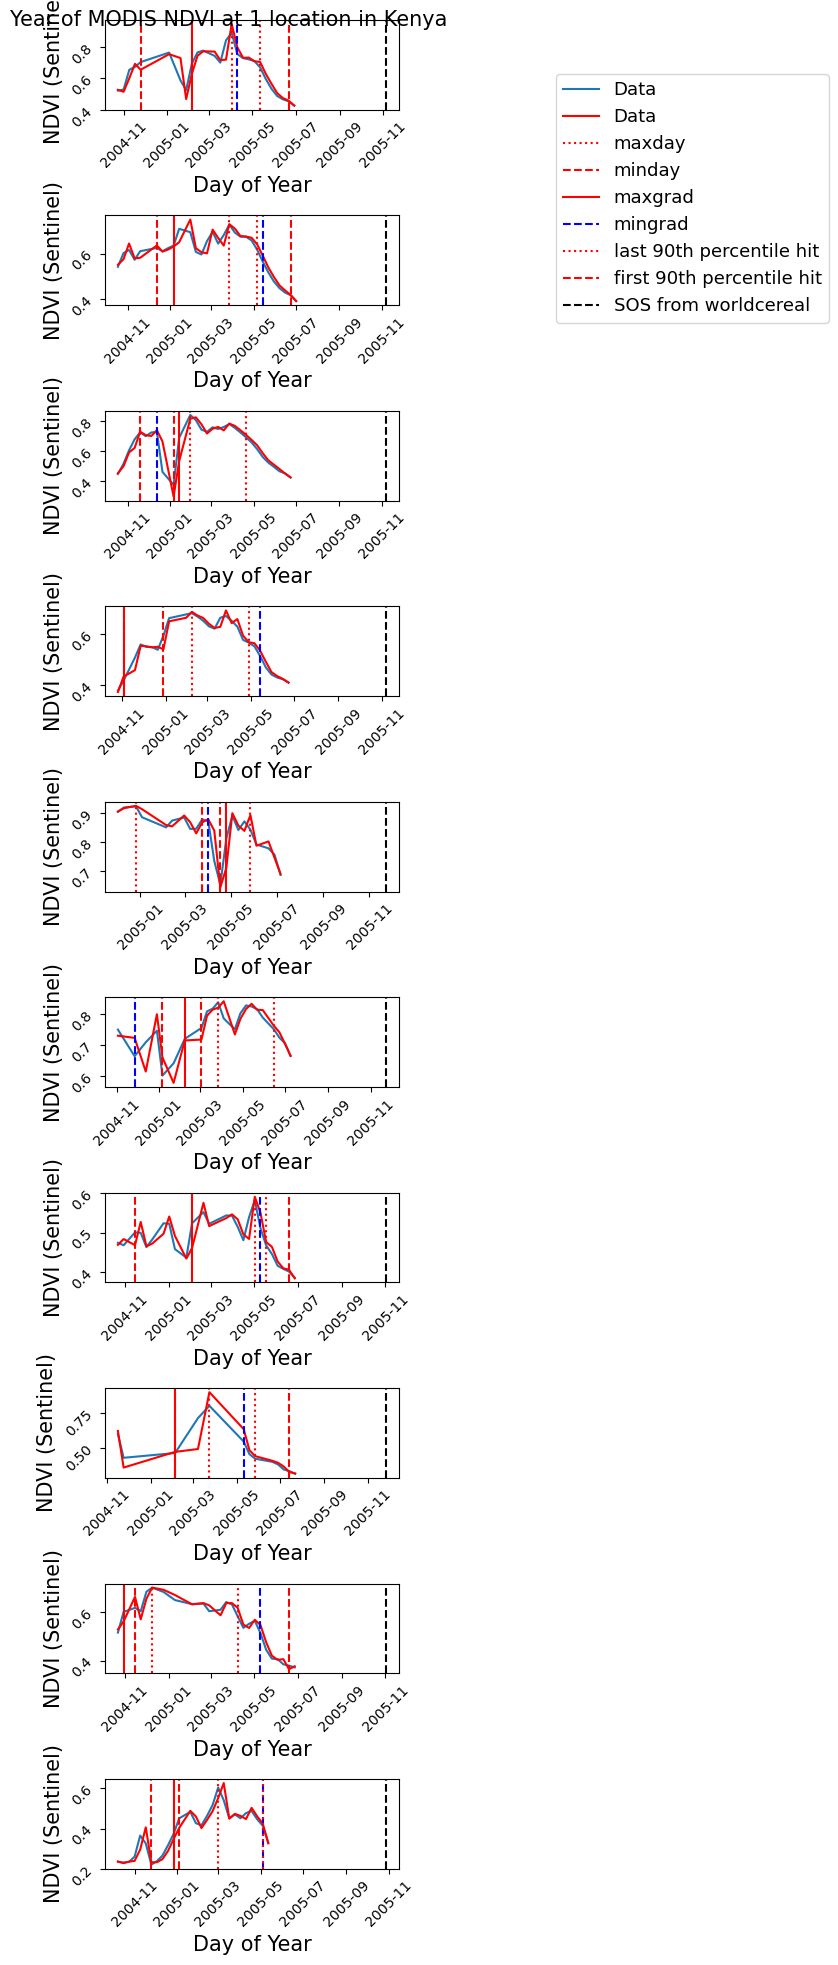

In [94]:
ds_list = []
for first_in_file in range(0, 110, 10):
    ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\CIMMYT_one_pixel_with_SOS_{first_in_file}.csv'))
ds = pd.concat(ds_list, axis = 0)
ds = prepare_obs_for_LSP(ds, instrument='MODIS')[1:]
ds['NDVI'] = ds['NDVI']
obs_data = phen_data_CIMMYT.copy()
obs_data = obs_data.drop(columns=['lat', 'lon'])#'Unnamed: 0', 
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
plot_many_NDVI_curves(ds, 2005, font_size = 15, curve='spline', window_length=4, variable_name='NDVI', interp_method='MVI')

In [59]:
LSP_frame_savgol = get_LSPs(1999, 2009, LSP_method = 'savgol', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=110, step=10, file_path='MODIS\\Kenya\\CIMMYT_one_pixel_with_SOS_', 
                    separate_year_files = False,
                    MVI_window= 6, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 20, phen_data = phen_data_CIMMYT)#1204
#LSP_frame_savgol.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_MODIS_SSA.csv')

Year: 1999
Station 1041.0 in 1999 has 0 observations so ignored
Station 517.0 in 1999 has 0 observations so ignored
Station 513.0 in 1999 has 0 observations so ignored
Station 896.0 in 1999 has 0 observations so ignored
Station 1042.0 in 1999 has 0 observations so ignored
Station 1056.0 in 1999 has 0 observations so ignored
Station 1051.0 in 1999 has 0 observations so ignored
Station 1067.0 in 1999 has 0 observations so ignored
Station 1055.0 in 1999 has 0 observations so ignored
Station 886.0 in 1999 has 0 observations so ignored
Year: 2000
10
10
10
10
11
Station 1056.0 in 2000 has 29 observations so ignored
10
11
11
10
Year: 2001
14
26
27
29
22
24
22
26
24
27
Year: 2002
19
27
25
24
25
25
24
27
24
27
Year: 2003
21
27
27
29
26
22
25
25
26
27
Year: 2004
20
26
27
28
22
23
23
23
23
26
Year: 2005
21
26
27
26
25
27
26
27
25
27
Year: 2006
21
26
26
25
23
25
23
26
26
27
Year: 2007
22
26
27
28
26
25
24
25
24
27
Year: 2008
Station 1041.0 in 2008 has 5 observations so ignored
10
10
Station 896.0 

In [10]:
file_path = 'MODIS\\Kenya\\CIMMYT_one_pixel'
for first_in_file in range(0, 110, 10):
    ds_MODIS = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}{first_in_file}.csv')
    ds_MODIS2 = add_SOS_EOS_to_df_CIMMYT(ds_MODIS)#.where((ds_MODIS['NDVI'] >0) & (ds_MODIS['reducer'] == 'mean')).dropna())
    ds_MODIS2.to_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}_with_SOS_{first_in_file}.csv')

-14.2 28.4
-29.28 27.5
-28.88 28.05
-26.553 31.165
-17.783 31.317
-18.8 31.6
-17.8 31.05
-20.35 32.33
-19.83 30.78
-26.67 27.07
-9.75 34.0
-15.18 34.62
-13.98 33.63
-13.13 34.07
-24.57 25.95
-23.03 26.517
-24.0 21.8
-25.48 25.47
-9.1 13.7
-5.6 12.2
-15.03 13.43
-12.73 15.83
-9.42 15.75
-24.53 33.0
-15.1 39.28
-15.5 28.3
-15.767 27.92
-14.17 28.37
-13.38 32.39
-2.719 33.024
-5.07 32.73
-3.18 36.7
-3.317 37.25
-25.79 31.06
-25.47 30.97
-17.8 31.05
-18.32 30.9
-21.02 31.58
-7.43 37.7
-8.133 36.683
-6.77 37.03
0.567 34.567
0.53 32.58
-15.92 35.07
-14.7 35.6
-12.1 33.5
-11.42 15.12
-19.33 33.22
-13.3 35.23
-10.1 31.1
-1.338 32.786
-3.25 35.8
9.1 37.15
-29.02 30.6
1.01 35.0
-16.16 33.59
-9.533 16.333
-17.32 31.57
-17.7 30.85
-29.367 27.917
-28.88 28.05
-19.83 30.78
-14.17 34.43
-11.45 33.917
-8.867 33.633
-3.23 37.88
-3.3 36.45
0.5333 34.1167
-0.25 31.25
1.483 35.467
-0.5 37.45
0.5 34.11
-16.47 34.92
-25.2 31.2
-9.1 13.7
0.53 32.58
1.517 33.45
-5.45 14.9
-5.07 38.92
-3.93 39.75
-15.526 27.45

In [29]:
phen_data_TZ = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_TZ.csv')
phen_data_ET = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_ET.csv')
file_path = 'MODIS\\Kenya\\TAMASA_Tanzania'
ds_MODIS = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}.csv')
ds_MODIS2 = add_SOS_EOS_to_df_CIMMYT(ds_MODIS, phen_data_CIMMYT=phen_data_TZ)#.where((ds_MODIS['NDVI'] >0) & (ds_MODIS['reducer'] == 'mean')).dropna())
ds_MODIS2.to_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}_with_SOS.csv')
file_path = 'MODIS\\Kenya\\TAMASA_Ethiopia'
ds_MODIS = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}.csv')
ds_MODIS2 = add_SOS_EOS_to_df_CIMMYT(ds_MODIS, phen_data_ET)#.where((ds_MODIS['NDVI'] >0) & (ds_MODIS['reducer'] == 'mean')).dropna())
ds_MODIS2.to_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}_with_SOS.csv')

-9.527 34.711
-9.399 33.6268
-7.7911 35.6984
-10.5413 36.0771
-8.9177 33.5158
-3.3595 36.6311
-3.2421 36.4114
-3.421 37.4475
-3.6435 37.6777
-3.016 37.0769
9.010056769 36.17036075
9.41844009 36.53997379
9.100395082 37.04366997
8.967523167 37.85994389
9.057301893 38.50313658
8.66889 39.44469694


In [25]:
print(ds_MODIS['lat'], phen_data_TZ['lat'].dropna())

0       -9.527
1       -9.527
2       -9.527
3       -9.527
4       -9.527
         ...  
21598   -3.016
21599   -3.016
21600   -3.016
21601   -3.016
21602   -3.016
Name: lat, Length: 21603, dtype: float64 0       9.010057
60      9.010083
120     9.010250
180     9.418440
240     9.418324
300     9.418214
360     9.100395
420     9.100357
480     9.100335
540     8.967523
600     8.967607
660     8.967685
720     9.057302
780     9.056396
840     9.055852
900     8.668890
960     8.668830
1020    8.668386
Name: lat, dtype: float64


In [17]:
lat = phen_data_TZ['lat'][0]
lon = phen_data_TZ['lon'][0]
print(WC_EOS_CIMMYT(lat, lon, phen_data_TZ))

148


In [11]:
lat = phen_data_CIMMYT['lat'][0]
lon = phen_data_CIMMYT['lon'][0]
EOS_SOS = phen_data_CIMMYT.loc[(phen_data_CIMMYT['lat'] == lat) & (phen_data_CIMMYT['lon'] == lon)][['SOS', 'EOS']].values[0]

array([314, 148], dtype=int64)

In [3]:
phen_data_TZ = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_TZ.csv')
phen_data_ET = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_ET.csv')

In [11]:
LSP_frame_linterp = get_LSPs(2017, 2022, LSP_method = 'linterp_raw', 
                    interp_method = 'linear', instrument='MODIS', 
                    last_index=1204, file_path='MODIS\\Germany3', 
                    MVI_window= 4, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 80)#1204

LSP_frame_linterp.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_linterp_MODIS_DE.csv')

Station 0
Year: 2017
Station 8015.0 in 2017 has 0 observations so ignored
Station 8053.0 in 2017 has 0 observations so ignored
Year: 2018
Station 7910.0 in 2018 has 1 observations so ignored
Station 8015.0 in 2018 has 1 observations so ignored
Station 8053.0 in 2018 has 0 observations so ignored
Year: 2019
Station 7956.0 in 2019 has 12 observations so ignored
Station 7990.0 in 2019 has 13 observations so ignored
Station 8053.0 in 2019 has 9 observations so ignored
Year: 2020
Station 7923.0 in 2020 has 15 observations so ignored
Year: 2021
Station 8015.0 in 2021 has 7 observations so ignored
Station 8053.0 in 2021 has 1 observations so ignored
Year: 2022
Station 8053.0 in 2022 has 7 observations so ignored
Station 40
Year: 2017
Station 8759.0 in 2017 has 0 observations so ignored
Station 8852.0 in 2017 has 3 observations so ignored
Station 8948.0 in 2017 has 2 observations so ignored
Station 8851.0 in 2017 has 0 observations so ignored
Station 8990.0 in 2017 has 0 observations so ignore

In [12]:
LSP_frame_MVI = get_LSPs(2017, 2022, LSP_method = 'MVI_raw', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=1204, file_path='MODIS\\Germany3', 
                    MVI_window= 4, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 80)#1204
LSP_frame_MVI.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_MVI_MODIS_DE.csv')

Station 0
Year: 2017
Station 8015.0 in 2017 has 0 observations so ignored
Station 8053.0 in 2017 has 0 observations so ignored
Year: 2018
Station 7910.0 in 2018 has 1 observations so ignored
Station 8015.0 in 2018 has 1 observations so ignored
Station 8053.0 in 2018 has 0 observations so ignored
Year: 2019
Station 7956.0 in 2019 has 12 observations so ignored
Station 7990.0 in 2019 has 13 observations so ignored
Station 8053.0 in 2019 has 9 observations so ignored
Year: 2020
Station 7923.0 in 2020 has 15 observations so ignored
Year: 2021
Station 8015.0 in 2021 has 7 observations so ignored
Station 8053.0 in 2021 has 1 observations so ignored
Year: 2022
Station 8053.0 in 2022 has 7 observations so ignored
Station 40
Year: 2017
Station 8759.0 in 2017 has 0 observations so ignored
Station 8852.0 in 2017 has 3 observations so ignored
Station 8948.0 in 2017 has 2 observations so ignored
Station 8851.0 in 2017 has 0 observations so ignored
Station 8990.0 in 2017 has 0 observations so ignore

In [4]:
LSP_frame_MVI = get_LSPs(2017, 2022, LSP_method = 'savgol_raw', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=1204, file_path='MODIS\\Germany3', 
                    MVI_window= 4, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 80)#1204
LSP_frame_MVI.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_MODIS_DE.csv')

Station 0
Year: 2017
Station 8015.0 in 2017 has 0 observations so ignored
Station 8053.0 in 2017 has 0 observations so ignored
Year: 2018
Station 7910.0 in 2018 has 1 observations so ignored
Station 8015.0 in 2018 has 1 observations so ignored
Station 8053.0 in 2018 has 0 observations so ignored
Year: 2019
Station 7956.0 in 2019 has 12 observations so ignored
Station 7990.0 in 2019 has 13 observations so ignored
Station 8053.0 in 2019 has 9 observations so ignored
Year: 2020
Station 7923.0 in 2020 has 15 observations so ignored
Year: 2021
Station 8015.0 in 2021 has 7 observations so ignored
Station 8053.0 in 2021 has 1 observations so ignored
Year: 2022
Station 8053.0 in 2022 has 7 observations so ignored
Station 40
Year: 2017
Station 8759.0 in 2017 has 0 observations so ignored
Station 8852.0 in 2017 has 3 observations so ignored
Station 8948.0 in 2017 has 2 observations so ignored
Station 8851.0 in 2017 has 0 observations so ignored
Station 8990.0 in 2017 has 0 observations so ignore

In [13]:
LSP_frame_MVI = get_LSPs(2017, 2022, LSP_method = 'savgol', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=1204, file_path='MODIS\\Germany3', 
                    MVI_window= 8, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 20)#1204
LSP_frame_MVI.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_MODIS_DE.csv')

Station 0
Year: 2017
Station 8015.0 in 2017 has 0 observations so ignored
Station 8053.0 in 2017 has 0 observations so ignored
Year: 2018
Station 7910.0 in 2018 has 0 observations so ignored
Station 8015.0 in 2018 has 0 observations so ignored
Station 8053.0 in 2018 has 0 observations so ignored
Year: 2019
Station 7956.0 in 2019 has 1 observations so ignored
Station 7990.0 in 2019 has 2 observations so ignored
Station 8053.0 in 2019 has 0 observations so ignored
Year: 2020
Station 7923.0 in 2020 has 6 observations so ignored
Year: 2021
Station 8015.0 in 2021 has 2 observations so ignored
Station 8053.0 in 2021 has 0 observations so ignored
Year: 2022
Station 8053.0 in 2022 has 3 observations so ignored
Station 40
Year: 2017
Station 8759.0 in 2017 has 0 observations so ignored
Station 8852.0 in 2017 has 0 observations so ignored
Station 8948.0 in 2017 has 0 observations so ignored
Station 8851.0 in 2017 has 0 observations so ignored
Station 8990.0 in 2017 has 0 observations so ignored
S

In [21]:
LSP_frame = get_LSPs(2017, 2022, LSP_method = 'variable_percentiles', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=1204, file_path='MODIS\\Germany3', 
                    MVI_window= 8, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 20)#1204

Station 0
Year: 2017
0 (48, 40)
1 (48, 40)
2 (48, 40)
3 (48, 40)
4 (48, 32)
5 (48, 32)
6 (48, 32)
7 (48, 32)
8 (56, 32)
9 (56, 32)
10 (56, 32)
11 (56, 32)
12 (56, 24)
13 (56, 24)
14 (56, 24)
15 (56, 24)
16 (64, 24)
17 (64, 24)
18 (64, 24)
19 (64, 24)
20 (64, 16)
21 (64, 16)
22 (64, 16)
23 (64, 16)
24 (72, 16)
25 (72, 16)
26 (72, 16)
0 (64, 56)
1 (64, 56)
2 (64, 56)
3 (64, 56)
0 (32, 24)
1 (32, 24)
2 (32, 24)
3 (32, 24)
4 (40, 24)
5 (40, 24)
6 (40, 24)
7 (40, 24)
Station 8015.0 in 2017 has 0 observations so ignored
Station 8053.0 in 2017 has 0 observations so ignored
Year: 2018
0 (184, 176)
1 (184, 176)
2 (184, 176)
3 (184, 176)
4 (184, 176)
5 (184, 168)
6 (184, 168)
7 (184, 168)
8 (184, 168)
9 (184, 160)
10 (184, 160)
11 (184, 160)
12 (184, 160)
13 (192, 160)
14 (192, 160)
15 (192, 160)
16 (192, 160)
17 (192, 152)
18 (192, 152)
19 (192, 152)
20 (192, 152)
21 (200, 152)
22 (200, 152)
23 (200, 152)
24 (200, 152)
0 (192, 184)
1 (192, 184)
2 (192, 184)
3 (192, 184)
4 (192, 176)
5 (192, 176

In [22]:
#LSP_frame.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_savgol.csv')
#LSP_frame.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_thresholds_dates.csv')
LSP_frame.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_varied_percentiles3.csv')

In [5]:
def plot_two_NDVI_curves(ds, index_1, index_2, year, font_size = 15, interp_method = 'linear', window_length=50, polyorder=2, variable_name = 'NDVI', save = False): #shift = 0, 
    fig, axs = plt.subplots(2, 1, figsize = (5, 6))
    for plot_index, obs_index in enumerate([index_1, index_2]):
        latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().dropna().iloc[obs_index]
        ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
        ds_year = data_cleaning.restrict_to_growing_season(ds_station, year, data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
        ds_interpolated = data_cleaning.resample_linear(ds_year)
        ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
        Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
        Tighter_times = np.arange(Times[0], Times[-1])
        NDVIs = ds_interpolated[variable_name].values
        first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
        axs[plot_index].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
        axs[plot_index].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), NDVIs, label = 'NDVI, linear interpolation', color = 'red')
        savgol_dates = savgol_LSP(NDVIs, Times, first_date, window_length=window_length)
        axs[plot_index].axvline(x = savgol_dates[1], color='r', label = 'Maximum gradient of smoothed curve')
        axs[plot_index].axvline(x = savgol_dates[0], color='b', linestyle='--', label = 'Minimum gradient of smoothed curve')
        axs[plot_index].axvline(x = savgol_dates[5], color='r', linestyle=':', label = 'last 75th percentile crossing')
        axs[plot_index].axvline(x = savgol_dates[4], color='r', linestyle='--', label = 'second last 75th percentile crossing')
        calendar_SOS = pd.to_datetime(f'{year}-01-01') + pd.Timedelta(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), 'D')
        axs[plot_index].axvline(x = calendar_SOS, color='k', linestyle='--', label = 'SOS from worldcereal')
        axs[plot_index].set_ylabel('NDVI (Sentinel)', fontsize = font_size)
        axs[plot_index].tick_params(labelrotation=45)
        axs[plot_index].set_title(f'location {plot_index + 1}', fontsize = font_size)
    axs[1].set_xlabel('Day of Year', fontsize = font_size)
    
    fig.suptitle('Year of Sentinel-2 NDVI data at 2 locations in Germany', fontsize = font_size)
    fig.tight_layout(w_pad=9)
    axs[0].legend(fontsize = font_size - 2, bbox_to_anchor=(1.15, 0.5))
    if save:
        fig.savefig('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\plots\\two_NDVI_curves.png', bbox_inches='tight')

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


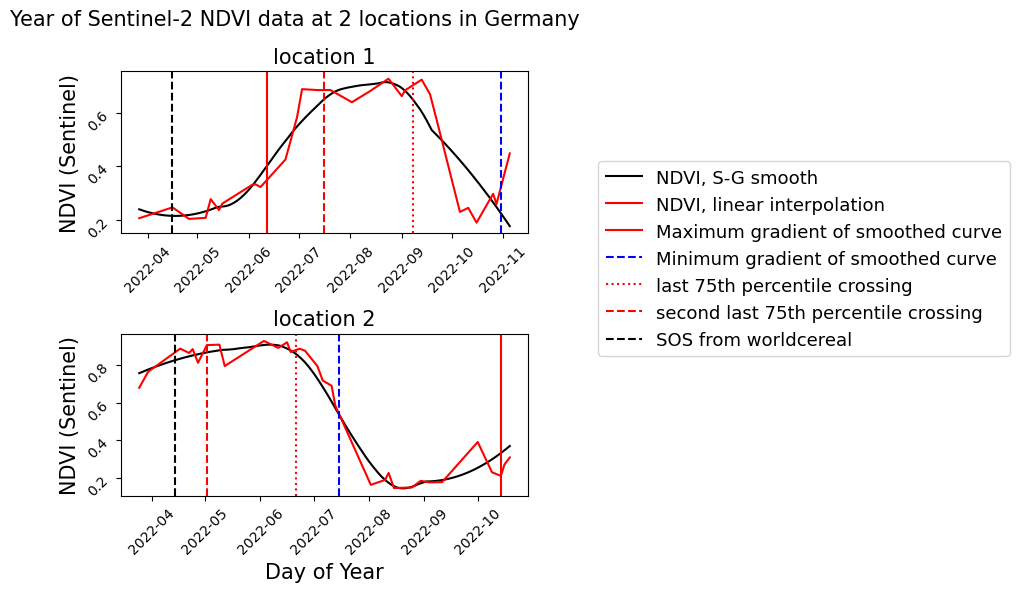

In [29]:
ds_list = []
for start_index in range(0, 25, 25):
    ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata{start_index}.csv'))
ds = pd.concat(ds_list, axis = 0)
#ds = pd.concat([ds1, ds2, ds3], axis = 0)
ds = ds.where(ds['NDVI'] != -9999).dropna()
ds = ds.where(ds['reducer'] == 'median').dropna()
ds['date'] = pd.to_datetime(ds['date'])
ds['year'] = ds['date'].dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
ds['NDVI2'] = normalized_difference(ds['B8'], ds['B4'])
plot_two_NDVI_curves(ds, 8, 1, 2022, font_size = 15, window_length=95, variable_name='NDVI', save=True)

In [93]:
def plot_many_NDVI_curves(ds, year, font_size = 15, interp_method = 'linear', 
                            curve = 'double_logistic', window_length=50, 
                            polyorder=2, variable_name = 'NDVI', data_type = 'dwd',
                            phen_data = None): #shift = 0, 
    fig, axs = plt.subplots(10, 1, figsize = (4, 20))
    location_index = 0
    #shift = 0
    failures = 0
    while location_index - failures < 10: #[4, 5, 6, 7, 8, 9]:#[3, 5, 6, 7, 9, 10, 12]:#[3, 4, 6, 7, 8, 9, 10, 12]:#[3, 4, 5, 6, 7, 8, 9, 10, 12]:#[20, 21, 23, 27]:# range(shift, shift + 10):#:#:
        latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().dropna().iloc[location_index]
        ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
        if data_type == 'dwd':
            ds_year = data_cleaning.restrict_to_growing_season(ds_station, year, data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
            calendar_SOS = pd.to_datetime(f'{year}-01-01') + pd.Timedelta(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), 'D')
        else:
            ds_station['date'] = pd.to_datetime(ds_station['date'])#, format='%Y-%m-%d-%H-%M-%S')
            for test_year in range(1999, 2007):
                try:
                    SOS_date = phen_data.loc[(phen_data['lon'] == latlon['lon']) & (phen_data['lat'] == latlon['lat']) & (phen_data['Referenzjahr'] == test_year)]['WC SOS date'].values[0]
                except:
                    print('WC SOS not available')
                    continue
                ds_station_year = ds_station.loc[(ds_station['date'] >= SOS_date) & (ds_station['date'] < SOS_date + np.timedelta64(220, 'D'))]
                if len(ds_station_year) > 0:
                    ds_year = ds_station_year
                    calendar_SOS = SOS_date
        #try:
        print(len(ds_year))
        
        #emergence_date = pd.to_datetime(ds_year['emergence date'].iloc[0])
        #observed_time_emergence_to_yellow_ripeness = pd.to_datetime(ds_year['emergence date'].iloc[0]) + pd.Timedelta(ds_year['observed time emergence to yellow ripeness'].iloc[0], 'D')
        #if pd.isnull(emergence_date - observed_time_emergence_to_yellow_ripeness):
        #    print('No emergence date')
        #    failures += 1
        #    location_index += 1
        #    continue
        if interp_method == 'linear':
            ds_interpolated = data_cleaning.resample_linear(ds_year)
        elif interp_method == 'MVI':
            ds_interpolated = data_cleaning.max_value_int(ds_year, window_size=8) #data_cleaning.
            print(len(ds_year))
            if len(ds_year) <9:
                print('too short after interpolation')
                location_index += 1
                failures += 1
                continue
            ds_interpolated = ds_interpolated.rename(columns = {'date': 'raw_time'}).reset_index().rename(columns = {'date': 'time'})
            ds_interpolated['NDVI'] = np.interp(ds_interpolated['time'], ds_interpolated['raw_time'], ds_interpolated['NDVI'])
            #return df_max_value_int_all
        #except:
        #    print('Couldn\'t interpolate')
        #    print(len(ds_year))
        #    failures += 1
        #    location_index += 1
        #    continue
        print(location_index, latlon['lat'], latlon['lon'])
        ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
        Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
        Tighter_times = np.arange(Times[0], Times[-1])
        #print(Times.shape, Tighter_times.shape)
        NDVIs = ds_interpolated[variable_name].values
        first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
        try:
            if curve == 'spline':
                spl = make_smoothing_spline(Times/365, NDVIs, lam = 0.00001)
                smoothed_series = pd.Series(spl(Tighter_times/365), index=Tighter_times/365)
            elif curve == 'double_logistic':
                params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
                smoothed_series = pd.Series(double_logistic(Tighter_times/365, *params), index=Tighter_times/365)
            #axs[location_index - failures].plot(ds_interpolated['time'].min() + pd.to_timedelta((smoothed_series.index)*365, 'D'), smoothed_series, label = 'Fit')
        except:
            print('Couldn\'t fit')
        if interp_method == 'linear':
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), NDVIs, label = 'NDVI, linear interpolation', color = 'red')
            #smoothed_derivs = scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder,  deriv=1)
            #axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), smoothed_derivs, label = 'NDVI, S-G smooth', color = 'black')
        else:
            axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'Data')
            axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), NDVIs, label = 'Data', color = 'red')
        #threshold_dates = variable_thresholds(NDVIs, Times, first_date, threshold_percentages = np.arange(0, 1, 0.1), smooth = True, window_length=window_length, polyorder=2)
        #print(threshold_dates)
        print(Times)
        #threshold_dates = first_date + pd.to_timedelta(np.array([*threshold_dates]), 'D')
        savgol_dates = savgol_LSP(NDVIs, Times, first_date, window_length=window_length)
        #smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0), index=Times)
        smoothed_derivs = pd.Series(scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder,  deriv=1), index=Times)
        mingrad = first_date + pd.Timedelta(smoothed_derivs.idxmin(), 'D')
        maxgrad = first_date + pd.Timedelta(smoothed_derivs.idxmax(), 'D')
        #minday = first_date + pd.Timedelta(smoothed_series.idxmin(), 'D')
        #maxday = first_date + pd.Timedelta(smoothed_series.idxmax(), 'D')
        axs[location_index - failures].axvline(x = savgol_dates[3], color='r', linestyle=':', label = 'maxday')
        axs[location_index - failures].axvline(x = savgol_dates[2], color='r', linestyle='--', label = 'minday')
        axs[location_index - failures].axvline(x = savgol_dates[1], color='r', label = 'maxgrad')
        axs[location_index - failures].axvline(x = savgol_dates[0], color='b', linestyle='--', label = 'mingrad')
        axs[location_index - failures].axvline(x = savgol_dates[5], color='r', linestyle=':', label = 'last 90th percentile hit')
        axs[location_index - failures].axvline(x = savgol_dates[4], color='r', linestyle='--', label = 'first 90th percentile hit')
        #axs[location_index - failures].axvline(x = threshold_dates[1], color='r', linestyle='--', label = 'first 0.1 threshold hit')
        #axs[location_index - failures].axvline(x = threshold_dates[5], color='b', linestyle='--', label = 'first 0.5 threshold hit')
        #axs[location_index - failures].axvline(x = threshold_dates[9], color='g', linestyle='--', label = 'first 0.9 threshold hit')
        #axs[location_index - failures].axvline(x = threshold_dates[11], color='r', linestyle=':', label = 'last 0.1 threshold hit')
        #axs[location_index - failures].axvline(x = threshold_dates[15], color='b', linestyle=':', label = 'last 0.5 threshold hit')
        #axs[location_index - failures].axvline(x = threshold_dates[19], color='g', linestyle=':', label = 'last 0.9 threshold hit')
        #emergence_date = pd.to_datetime(ds_year['emergence date'].iloc[0])
        #try:
        #    axs[location_index - failures].axvline(x = emergence_date, color='green', label = 'emergence date')
        #except:
        #    print('No emergence date')
        calendar_SOS = pd.to_datetime(f'{year}-01-01') + pd.Timedelta(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), 'D')
        axs[location_index - failures].axvline(x = calendar_SOS, color='k', linestyle='--', label = 'SOS from worldcereal')
        #try:
        #    observed_time_emergence_to_yellow_ripeness = pd.to_datetime(ds_year['emergence date'].iloc[0]) + pd.Timedelta(ds_year['observed time emergence to yellow ripeness'].iloc[0], 'D')
        #    axs[location_index - failures].axvline(x = observed_time_emergence_to_yellow_ripeness, color='green', linestyle=':', label = 'observed ripeness')
        #    axs[location_index - failures].legend(fontsize = font_size - 2, bbox_to_anchor=(1.5, 0.5))
        #except:
        #    print('no maturity data')

        axs[location_index - failures].set_xlabel('Day of Year', fontsize = font_size)
        axs[location_index - failures].set_ylabel('NDVI (Sentinel)', fontsize = font_size)
        axs[location_index - failures].tick_params(labelrotation=45)
        location_index += 1
    fig.suptitle('Year of MODIS NDVI at 1 location in Kenya', fontsize = font_size)
    fig.tight_layout()
    axs[0].legend(fontsize = font_size - 2, bbox_to_anchor=(1.5, 0.5))
    print(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']))
    print(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
    print(f'There were {failures} failures')
        

116
0 54.3167 10.05


TypeError: variable_thresholds() missing 1 required positional argument: 'first_date'

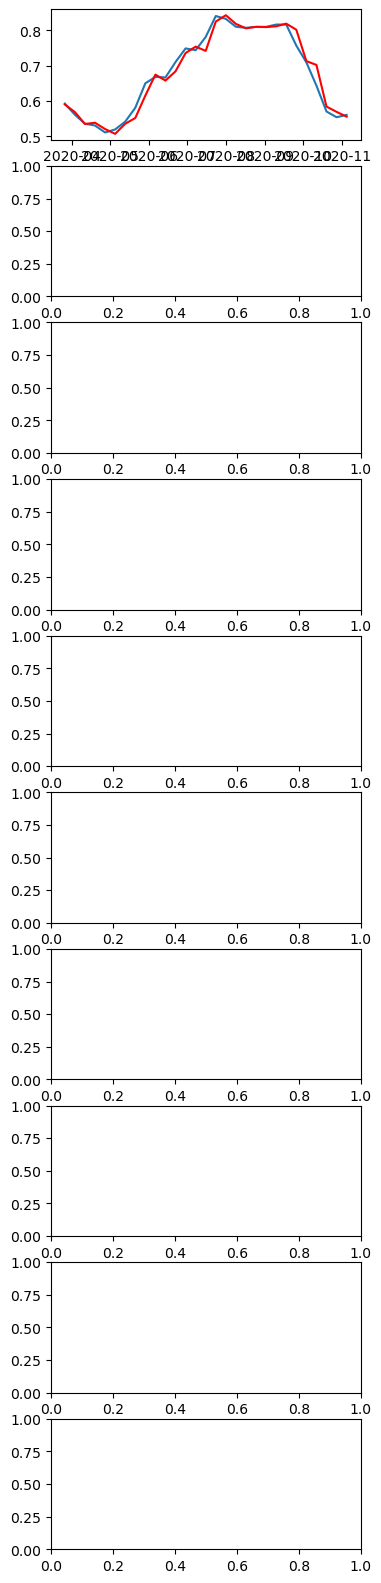

In [76]:
ds_list = []
for start_index in range(0, 1200, 40):
    for year in [2017, 2018, 2019, 2020, 2021, 2022]:
        ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany3\\satdata{start_index}_{year}.csv')) #Sentinel
ds = pd.concat(ds_list, axis = 0)
ds = prepare_obs_for_LSP(ds, instrument='MODIS')[1:]
ds['NDVI'] = ds['NDVI']
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
plot_many_NDVI_curves(ds, 2020, font_size = 15, curve='spline', window_length=4, variable_name='NDVI', interp_method='MVI')

In [8]:
def plot_long_NDVI_curves(ds, start_year, end_year, interp_method = 'linear', variable_name = 'NDVI', window_length=50, polyorder=2, font_size = 20):
    fig, axs = plt.subplots(10, 1, figsize = (4, 20))
    location_index = 0
    #shift = 0
    failures = 0
    while location_index - failures < 10: #[4, 5, 6, 7, 8, 9]:#[3, 5, 6, 7, 9, 10, 12]:#[3, 4, 6, 7, 8, 9, 10, 12]:#[3, 4, 5, 6, 7, 8, 9, 10, 12]:#[20, 21, 23, 27]:# range(shift, shift + 10):#:#:
        latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().dropna().iloc[location_index]
        ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
        ds_year = ds_station.loc[(ds_station['year'] >= start_year) & (ds_station['year'] <= end_year)]
        try:
            if interp_method == 'linear':
                ds_interpolated = data_cleaning.resample_linear(ds_year)
            elif interp_method == 'MVI':
                ds_interpolated = data_cleaning.max_value_int(ds_year, window_size=8) #data_cleaning.
        except:
            print('Couldn\'t interpolate')
            failures += 1
            location_index += 1
            continue
        print(location_index, latlon['lat'], latlon['lon'])
        ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
        Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
        Tighter_times = np.arange(Times[0], Times[-1])
        #print(Times.shape, Tighter_times.shape)
        NDVIs = ds_interpolated[variable_name].values
        first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
        if interp_method == 'linear':
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), NDVIs, label = 'NDVI, linear interpolation', color = 'red')
            #smoothed_derivs = scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder,  deriv=1)
            #axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), smoothed_derivs, label = 'NDVI, S-G smooth', color = 'black')
        else:
            axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'Data')
            axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), NDVIs, label = 'Data', color = 'red')
        for year in range(start_year, end_year + 1):
            SOS = np.datetime64(f'{year}-01-01') + pd.to_timedelta(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), 'D')
            EOS = np.datetime64(f'{year}-01-01') + pd.to_timedelta(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']), 'D')
            axs[location_index - failures].axvline(SOS, c = 'red', label = 'SOS')
            axs[location_index - failures].axvline(EOS, c = 'blue', label = 'EOS')
        axs[location_index - failures].set_xlabel('Day of Year', fontsize = font_size)
        axs[location_index - failures].set_ylabel('NDVI (Sentinel)', fontsize = font_size)
        axs[location_index - failures].tick_params(labelrotation=45)
        location_index += 1
    fig.suptitle('7 years of Sentinel NDVI at 1 location in Kenya', fontsize = font_size)
    fig.tight_layout()
    axs[0].legend(fontsize = font_size - 2, bbox_to_anchor=(1.5, 0.5))
    print(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']))
    print(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
    print(f'There were {failures} failures')

In [ ]:
ds_list = []
for start_index in range(0, 25, 25):
    ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata{start_index}.csv'))
ds = pd.concat(ds_list, axis = 0)
#ds = pd.concat([ds1, ds2, ds3], axis = 0)
ds = ds.where(ds['NDVI'] != -9999).dropna()
ds = ds.where(ds['reducer'] == 'median').dropna()
ds['date'] = pd.to_datetime(ds['date'])
ds['year'] = ds['date'].dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
ds['NDVI2'] = normalized_difference(ds['B8'], ds['B4'])
plot_long_NDVI_curves(ds, 2019, 2022, font_size = 15, window_length=95, variable_name='NDVI2')